In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from casadi import*

In [67]:
mpl.rcParams['font.size'] = 16

In [68]:
A=np.array([[1.1,1],
          [0,1]])
nx=A.shape[1]
print(nx)
print('A.shape ={}'.format(A.shape))

2
A.shape =(2, 2)


In [69]:
B=np.array([[0.5],[1]])
nu=B.shape[1]
print(nu)
print('B.shape ={}'.format(B.shape))

1
B.shape =(2, 1)


In [70]:
x=SX.sym("x",nx,1)
u=SX.sym("u",nu,1)
w=SX.sym("w",2,1)

In [71]:
x_next=A@x + B@u +w

system = Function("sys",[x,u,w],[x_next])

print(x_next)

[((((1.1*x_0)+x_1)+(0.5*u))+w_0), ((x_1+u)+w_1)]


In [72]:
x0=np.ones((2,1))
u0=np.ones((1,1))
w0=np.array([0.1,0.1]).reshape(2,1)
x_next=system(x0,u0,w0)
print(x_next)

[2.7, 2.1]


In [73]:
N_sim=10
x_0 = np.array([2,1]).reshape(2,1)
u_k =np.array([0]).reshape(1,1)
w_k=np.array([0.12,0.12]).reshape(2,1)
res_x=[x_0]

In [74]:
for i in range(N_sim):
    x_k =  system(x_0,u_k,w_k)
    res_x.append(x_k)
    x_0 = x_k
    
res_x = np.concatenate(res_x,axis=1)
print(res_x)

[[ 2.          3.32        4.892       6.7412      8.89532    11.384852
  14.2433372  17.50767092 21.21843801 25.42028181 30.16230999]
 [ 1.          1.12        1.24        1.36        1.48        1.6
   1.72        1.84        1.96        2.08        2.2       ]]


In [75]:
res_x.shape

(2, 11)

Text(0.5, 0, 'time')

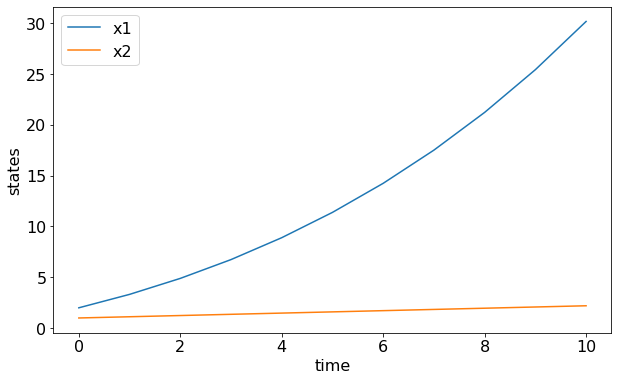

In [76]:
fig,ax =plt.subplots(figsize=(10,6))

lines=ax.plot(res_x.T)
ax.legend(lines, ['x1','x2'])

ax.set_ylabel('states')
ax.set_xlabel('time')



In [77]:
Q=1
Q=Q*np.diag(np.ones(nx))
print(Q)
R=0.1
R=np.diag(R*np.ones(nu))
print(R)
N=10

[[1. 0.]
 [0. 1.]]
[[0.1]]


In [78]:
stage_cost=x.T@Q@x+u.T@R@u
stage_cost_fcn=Function('stage_cost',[x,u],[stage_cost])
terminal_cost=x.T@Q@x
terminal_cost_fcn=Function('terminal_cost',[x],[terminal_cost])

In [79]:
lb_x = -2*np.ones((nx,1))
ub_x = 2*np.ones((nx,1))
# input constraints
lb_u = -1*np.ones((nu,1))
ub_u = 1*np.ones((nu,1))

In [80]:
X=SX.sym("X",(N+1)*nx,1)
U=SX.sym("U",(N)*nu,1)
print(U)
print(X)

[U_0, U_1, U_2, U_3, U_4, U_5, U_6, U_7, U_8, U_9]
[X_0, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9, X_10, X_11, X_12, X_13, X_14, X_15, X_16, X_17, X_18, X_19, X_20, X_21]


In [81]:
J=0
lb_X=[]
ub_X=[]
lb_U=[]
ub_U=[]
g=[]
lb_g=[]
ub_g=[]

In [82]:
for k in range(N):
    
    x_k = X[k*nx:(k+1)*nx,:]
    x_k_next = X[(k+1)*nx:(k+2)*nx,:]
    u_k = U[k*nu:(k+1)*nu,:]
    
    J+=stage_cost_fcn(x_k,u_k)
    
    x_k_next_calc=system(x_k,u_k,w_k)
    
    g.append(x_k_next - x_k_next_calc)
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    
    
    lb_X.append(lb_x)
    ub_X.append(ub_x)
    
    lb_U.append(lb_u)
    ub_U.append(ub_u)
    


In [83]:
x_terminal=X[N*nx:(N+1)*nx]
J+=terminal_cost_fcn(x_terminal)
lb_X.append(lb_x)
ub_X.append(ub_x)
print(len(lb_U))
print(len(ub_U))

10
10


In [84]:
print(X)
print(U)

[X_0, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9, X_10, X_11, X_12, X_13, X_14, X_15, X_16, X_17, X_18, X_19, X_20, X_21]
[U_0, U_1, U_2, U_3, U_4, U_5, U_6, U_7, U_8, U_9]


In [85]:
x=vertcat(X,U)
lbx=vertcat(*lb_X,*lb_U)
ubx=vertcat(*ub_X,*ub_U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)
print(J.shape)
print(X.shape)
print(U.shape)

(1, 1)
(22, 1)
(10, 1)


In [86]:
prob = {'f':J,'x':x,'g':g}
solver=nlpsol('solver','ipopt', prob)

In [87]:
print(solver)

solver:(x0[32],p[],lbx[32],ubx[32],lbg[20],ubg[20],lam_x0[32],lam_g0[20])->(x[32],f,g[20],lam_x[32],lam_g[20],lam_p[]) IpoptInterface


In [88]:
x_0 = np.array([-2,2]).reshape(2,1)
lbx[:nx]=x_0
ubx[:nx]=x_0
print(lbx.shape)
print(ubx.shape)

(32, 1)
(32, 1)


In [89]:
res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)

X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
U = res['x'][(N+1)*nx:].full().reshape(N, nu)


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       67
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       30

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

In [90]:
print(U.shape)

(10, 1)


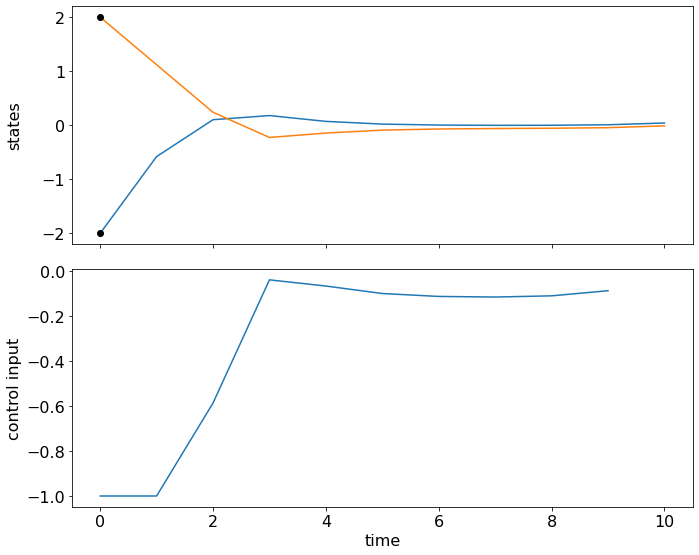

In [91]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(X)
ax[1].plot(U)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()

In [92]:
x_0 = np.array([2,-2]).reshape(2,1)
res_x = [x_0]
res_u = []
print(x_0)
N_sim = 20

[[ 2]
 [-2]]


In [93]:
for i in range(N_sim):
    # fix initial condition of the state:
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    print(lbx)
    print(ubx)
    # solve optimization problem
    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)
    u_k = res['x'][(N+1)*nx:(N+1)*nx+nu,:]
    print(u_k.shape)
    
    res_u.append(u_k)
    print(res_u)
    
    # simulate the system
    x_next = system(x_0,u_k,w_k)
    res_x.append(x_next)
    x_0 = x_next
    print(res_x)
# Make an array from the list of arrays:
res_x = np.concatenate(res_x,axis=1)
res_u = np.concatenate(res_u, axis=1)

[2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[2, -2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       67
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       30

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:

   0 3.5681680e-003 1.20e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 5.0020867e-002 2.26e-017 7.23e-003  -1.0 1.21e-001    -  9.70e-001 1.00e+000h  1
   2 4.8574912e-002 2.08e-017 1.29e-004  -2.5 2.77e-002    -  9.99e-001 1.00e+000f  1
   3 4.8561697e-002 2.34e-017 2.45e-017  -3.8 3.46e-003    -  1.00e+000 1.00e+000f  1
   4 4.8561696e-002 2.17e-017 2.55e-017  -5.7 3.28e-005    -  1.00e+000 1.00e+000h  1
   5 4.8561696e-002 2.86e-017 2.85e-017  -8.6 1.28e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  4.8561695855959500e-002   4.8561695855959500e-002
Dual infeasibility......:  2.8459777632152457e-017   2.8459777632152457e-017
Constraint violation....:  2.8622937353617317e-017   2.8622937353617317e-017
Complementarity.........:  2.5061467733068704e-009   2.5061467733068704e-009
Overall NLP error.......:  2.5061467733068704e-009   2.5061467733068704e-00

(1, 1)
[DM(0.933651), DM(0.45187), DM(0.0908542), DM(-0.0494083), DM(-0.0971233), DM(-0.112674), DM(-0.117665), DM(-0.119257), DM(-0.119764), DM(-0.119925), DM(-0.119976), DM(-0.119992), DM(-0.119998), DM(-0.119999), DM(-0.12), DM(-0.12), DM(-0.12), DM(-0.12), DM(-0.12), DM(-0.12)]
[array([[ 2],
       [-2]]), DM([0.786825, -0.946349]), DM([0.265094, -0.374479]), DM([0.082551, -0.163625]), DM([0.022477, -0.0930332]), DM([0.0031299, -0.0701565]), DM([-0.00305083, -0.062831]), DM([-0.00501929, -0.0604958]), DM([-0.00564546, -0.0597527]), DM([-0.00584456, -0.0595164]), DM([-0.00590786, -0.0594413]), DM([-0.00592798, -0.0594174]), DM([-0.00593438, -0.0594098]), DM([-0.00593641, -0.0594074]), DM([-0.00593705, -0.0594066]), DM([-0.00593726, -0.0594064]), DM([-0.00593733, -0.0594063]), DM([-0.00593735, -0.0594063]), DM([-0.00593735, -0.0594063]), DM([-0.00593736, -0.0594063]), DM([-0.00593736, -0.0594063])]


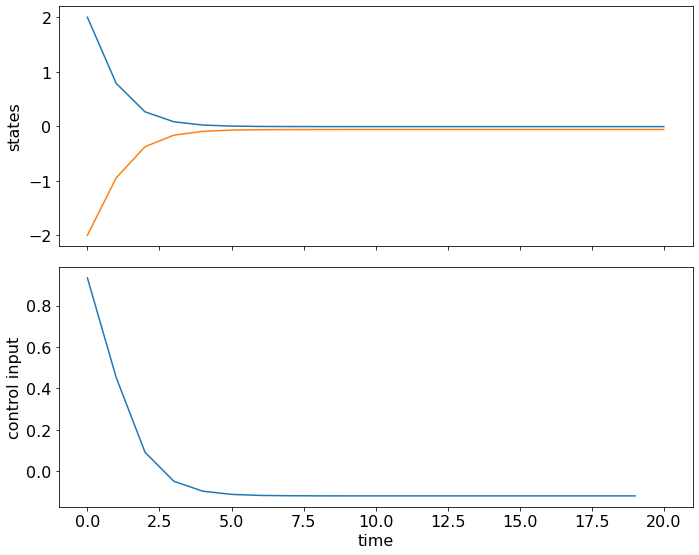

In [94]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(res_x.T)
ax[1].plot(res_u.T)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

fig.align_ylabels()
fig.tight_layout()